In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.statespace.sarimax import SARIMAX

In [ ]:
# Lokasi file CSV di Google Drive
file_path = "/content/drive/MyDrive/test/Electric_Production.csv"

# Membaca file CSV dan menyimpannya ke dalam DataFrame
data = pd.read_csv(file_path)

# Tampilkan data
print(data)

          DATE  IPG2211A2N
0     1/1/1985     72.5052
1     2/1/1985     70.6720
2     3/1/1985     62.4502
3     4/1/1985     57.4714
4     5/1/1985     55.3151
..         ...         ...
392   9/1/2017     98.6154
393  10/1/2017     93.6137
394  11/1/2017     97.3359
395  12/1/2017    114.7212
396   1/1/2018    129.4048

[397 rows x 2 columns]


In [ ]:
# Mengubah kolom 'DATE' menjadi tipe data datetime
data['DATE'] = pd.to_datetime(data['DATE'])

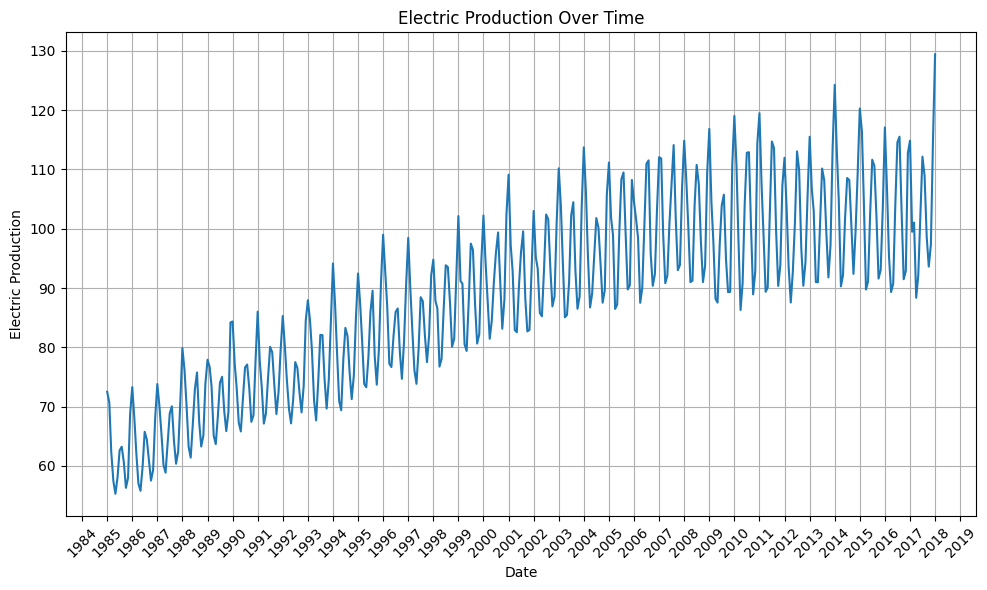

In [ ]:
# Memplot data 'IPG2211A2N'
plt.figure(figsize=(10, 6))
plt.plot(data['DATE'], data['IPG2211A2N'])
plt.xlabel('Date')
plt.ylabel('Electric Production')
plt.title('Electric Production Over Time')

# Format date ticks on x-axis
date_form = mdates.DateFormatter("%Y")  # Format: "2022" (tahun saja)
plt.gca().xaxis.set_major_formatter(date_form)
plt.gca().xaxis.set_major_locator(mdates.YearLocator())  # Menampilkan label setiap tahun
plt.xticks(rotation=45)

plt.grid(True)
plt.tight_layout()
plt.show()

In [ ]:
# Menampilkan tipe data dari setiap kolom di dalam DataFrame
print(data.dtypes)

DATE          datetime64[ns]
IPG2211A2N           float64
dtype: object


# **Perhitungan Mean dan Median Data pada Setiap Triwulan**

In [ ]:
# Membuat kolom baru "quarter" untuk menandai triwulan dari tiap data
data['quarter'] = data['DATE'].dt.quarter
print(data['quarter'])

0      1
1      1
2      1
3      2
4      2
      ..
392    3
393    4
394    4
395    4
396    1
Name: quarter, Length: 397, dtype: int64


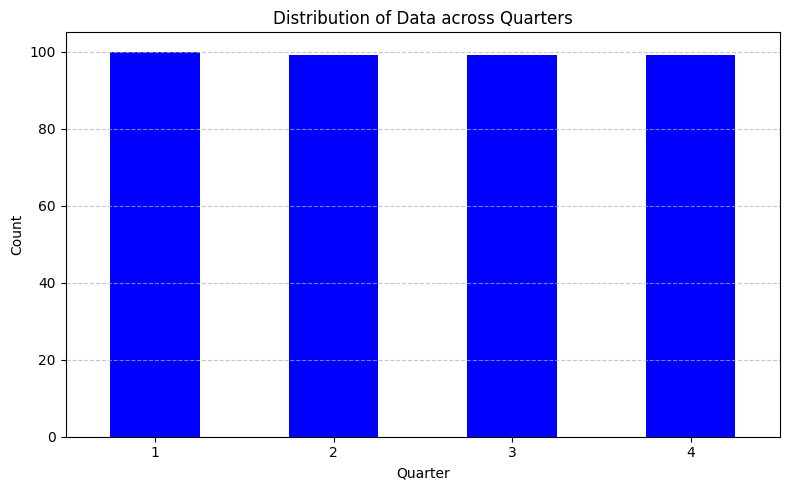

In [ ]:
# Memplot data quarter menggunakan bar plot
plt.figure(figsize=(8, 5))
data['quarter'].value_counts().sort_index().plot(kind='bar', color='blue')
plt.xlabel('Quarter')
plt.ylabel('Count')
plt.title('Distribution of Data across Quarters')
plt.xticks(rotation=0)  # Rotates x-axis labels if needed
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

In [ ]:
# Menghitung rata-rata produksi listrik per triwulan
rata_rata_per_triwulan = data.groupby('quarter')['IPG2211A2N'].mean()

# Menghitung median produksi listrik per triwulan
median_per_triwulan = data.groupby('quarter')['IPG2211A2N'].median()

In [ ]:
# Tampilkan hasil rata-rata dan median per triwulan
print("Rata-rata Produksi Listrik per Triwulan:")
print(rata_rata_per_triwulan)

print("\nMedian Produksi Listrik per Triwulan:")
print(median_per_triwulan)

Rata-rata Produksi Listrik per Triwulan:
quarter
1    94.773492
2    81.988264
3    92.199718
4    86.367535
Name: IPG2211A2N, dtype: float64

Median Produksi Listrik per Triwulan:
quarter
1    95.37885
2    85.46530
3    95.76320
4    88.92510
Name: IPG2211A2N, dtype: float64


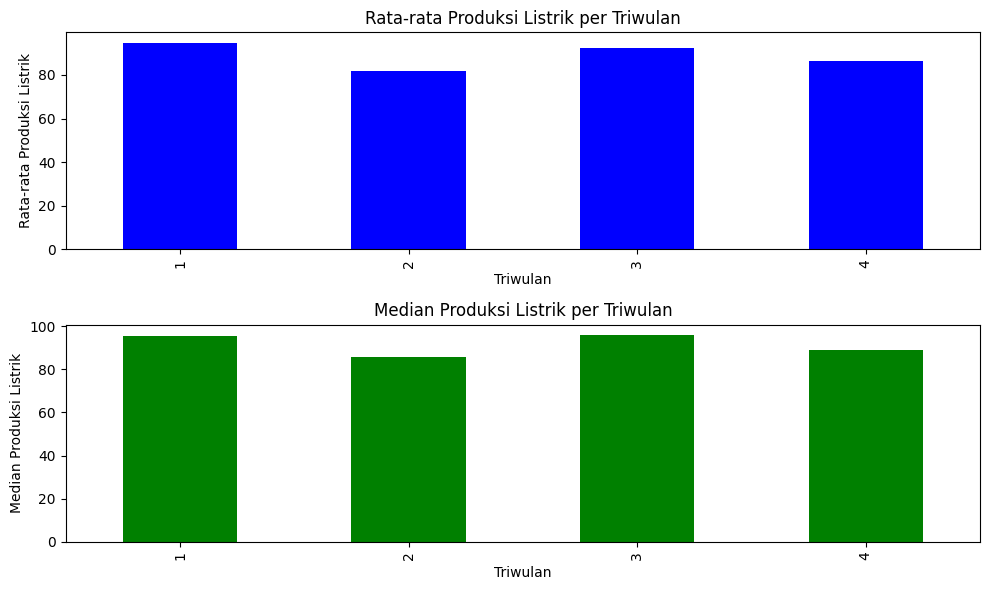

In [ ]:
# Plot bar terpisah untuk rata-rata dan median per triwulan
plt.figure(figsize=(10, 6))

# Plot bar untuk rata-rata per triwulan
plt.subplot(2, 1, 1)
rata_rata_per_triwulan.plot(kind='bar', color='blue')
plt.title('Rata-rata Produksi Listrik per Triwulan')
plt.xlabel('Triwulan')
plt.ylabel('Rata-rata Produksi Listrik')

# Plot bar untuk median per triwulan
plt.subplot(2, 1, 2)
median_per_triwulan.plot(kind='bar', color='green')
plt.title('Median Produksi Listrik per Triwulan')
plt.xlabel('Triwulan')
plt.ylabel('Median Produksi Listrik')

plt.tight_layout()
plt.show()

# **Stationary Test pada Data**

In [ ]:
# Lakukan ADF Test pada kolom 'IPG2211A2N'
result = adfuller(data['IPG2211A2N'])

In [ ]:
# Tampilkan hasil ADF Test
print("Hasil ADF Test:")
print("ADF Statistic:", result[0])
print("p-value:", result[1])
print("Lags Used:", result[2])
print("Observations Used:", result[3])
print("Critical Values:")
for key, value in result[4].items():
    print(f"\t{key}: {value}")

Hasil ADF Test:
ADF Statistic: -2.256990350047235
p-value: 0.1862146911658712
Lags Used: 15
Observations Used: 381
Critical Values:
	1%: -3.4476305904172904
	5%: -2.869155980820355
	10%: -2.570827146203181


In [ ]:
# Interpretasi hasil ADF Test
if result[1] <= 0.05:
    print("Data bersifat stasioner.")
else:
    print("Data tidak bersifat stasioner.")

Data tidak bersifat stasioner.


# **Melakukan Prediksi Konsumsi Listrik 6 Bulan Kedepan**

In [ ]:
# Set kolom "date" sebagai index
data.set_index('DATE', inplace=True)

In [ ]:
# Bagi data menjadi data pelatihan dan data validasi
train_data = data['IPG2211A2N']  # Mengambil semua data
validation_data = data['IPG2211A2N'].iloc[-6:]  # Mengambil 6 bulan terakhir sebagai data validasi

In [ ]:
# Membuat model SARIMA (p,d,q)(P,D,Q,m)
order = (1, 1, 1)  # Order ARIMA (p, d, q)
seasonal_order = (1, 1, 1, 4)  # Order Seasonal ARIMA (P, D, Q, m)
model = SARIMAX(train_data, order=order, seasonal_order=seasonal_order)

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


In [ ]:
# Fitting model ke data pelatihan
results = model.fit()

In [ ]:
# Lakukan prediksi untuk 6 bulan ke depan
forecast = results.forecast(steps=6)

In [ ]:
# Print hasil prediksi
print("Hasil Prediksi Konsumsi Listrik selama 6 Bulan ke Depan:")
print(forecast)

Hasil Prediksi Konsumsi Listrik selama 6 Bulan ke Depan:
2018-02-01    132.007736
2018-03-01    132.910377
2018-04-01    128.299922
2018-05-01    122.278029
2018-06-01    118.860484
2018-07-01    120.505551
Freq: MS, Name: predicted_mean, dtype: float64


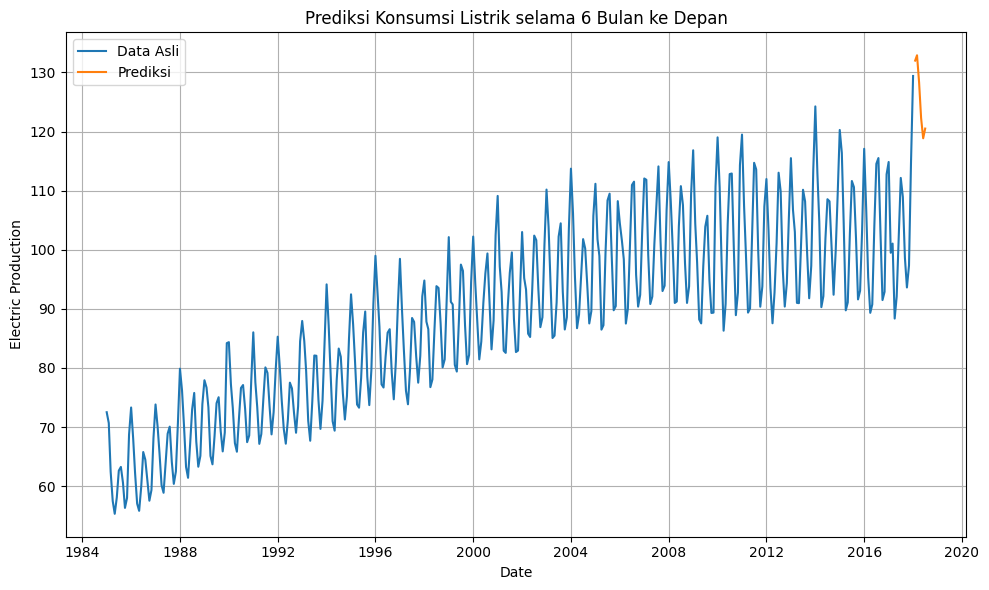

In [ ]:
# Plot hasil prediksi bersama dengan data asli
plt.figure(figsize=(10, 6))
plt.plot(data.index, data['IPG2211A2N'], label='Data Asli')
plt.plot(forecast.index, forecast, label='Prediksi')
plt.xlabel('Date')
plt.ylabel('Electric Production')
plt.title('Prediksi Konsumsi Listrik selama 6 Bulan ke Depan')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [ ]:
import numpy as np
from sklearn.metrics import mean_squared_error

# Mengganti index dari forecast dengan index dari data validasi
forecast.index = validation_data.index

# Menghitung MSE
mse = mean_squared_error(validation_data, forecast)

# Menghitung RMSE
rmse = np.sqrt(mse)

print("MSE:", mse)
print("RMSE:", rmse)

MSE: 605.0410101071608
RMSE: 24.597581387347024
